# Network construction & Community detection--Twitter data

### We are given the data from tweeter, recording users' ID and the time and location when they post anything. Our basic idea is to construct a network where we observe the relation among places by analyzing people's activities near each location, trying to detect grouping communities and distinguish weak links from strong ones.

### Step 1,  load the data from twitter and categorize it by weekdays/weekend

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import networkx as nx #library supporting networks
#import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline 
#import statsmodels.formula.api as smf
import scipy
import numpy as np
import pandas as pd
from datetime import datetime
import csv
import matplotlib
from mpl_toolkits import basemap
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon
#from matplotlib import colors
from mpl_toolkits.basemap import shapefile as shp
#from scipy import optimize
import community #Louvain method

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`


Populating the interactive namespace from numpy and matplotlib


Convert time stamp into datetime format and then create four different datasets:
1. All data, labeled  **AllData**
2. Data from weekdays, labeled  **WkdData**
3. Data from Saturdays, labeled  **SatData**
4. Data from Sundays, labeled  **SunData**

In [2]:
zipsf = shp.Reader('/Users/CQ/Documents/Project1/ManhattanStreetMap/cb_2014_us_zcta510_500k.shp')
zipsf_records = zipsf.records()
zipsf_shape = zipsf.shapeRecords()

In [3]:
twitter_file = pd.read_csv('2016_02_18_sintetic.csv')
USzipcode = pd.read_csv('USzipcode_XY.csv')

list1 = [datetime.fromtimestamp(x) for x in twitter_file.timestamp]
list2, list3, list4 = [], [], []

for x in list1:
    if datetime.weekday(x) == 5:
        list3.append(x)
    elif datetime.weekday(x) == 6:
        list4.append(x)
    else:
        list2.append(x)
twitter_file.iloc[:,0] = list1

twitter_file.columns = ['DateTime','Stamp','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']

In [4]:
AllData = twitter_file
WkdData = AllData[AllData.DateTime.isin(list2)]
SatData = AllData[AllData.DateTime.isin(list3)]
SunData = AllData[AllData.DateTime.isin(list4)]

### Step 2, construct a network with a form of "(zip1), (zip2), (number of people who visited both places)"

Next we start our counting process. We build our function Network_build to do such things, and our input argument is the weekday filter(e.g. Saturdays, or all weekdays)

Basically for each senario, we list all the possible zipcodes, then we observe each individual to determine whether or not that place has been visited. Each person has a matrix "count_mat" and count_total is to store the total visits on each possible pair of locations, such as (10001, 10007). 

(Note that we've stored it in a matrix and since right now we consider undirected graph so pair (10001, 10007) and pair (10007, 10001) are identical, which means our matrix is symmetric. In the future, if we ever want to consider directed graph and find of way of modeling it, we shall distinguish entry $a_{i,j}$ from $a_{j,i}$）

First define a function to analyze and count places visited by each individual, categorized by his userid
* *Week 2, add loop edges to the network (Fast solution: define the link between a zip code A with itself as a number of users who twitted in the zip code at least twice))*

In [5]:
def count_that_person(dataFrame, column_name, userid, lzip, zipcode):
    temp = dataFrame[dataFrame[column_name].values == userid].ZipCode
    allzip = list(set(temp))
    #allzip is the list containing all the places this user has visited
    count_mat = np.zeros([lzip,lzip], dtype = int)
    for i in range(len(allzip)):
        j = zipcode.index(allzip[i])
        count_mat[j,:] += 1
        count_mat[:,j] += 1
        #next if-statement is for adding loop edges--added in week 2
        if len(temp[temp.isin([allzip[i]])]) < 2:
            count_mat[j,j] -= 1
    count_mat /= 2
    return count_mat

Next accumulate all people's activities in "count_total", and eventually we construct the basic network where we assume every pair of two locations are connected, the only difference is their popularity.
* *Week 2, for those places that have been visited more than once by the same individual, we add a loop edge for that person.*

In [6]:
def Network_build(date_index = 1):
    """This function is for initializing our network with the form of
    (zip1), (zip2), (number of people who visited both places)
    And the input argument is the date_index where indice 1, 2, 3, 4
    indicate AllData, Weekdays, Saturdays and Sundays, respectively,
    with index 1 being the default value"""
    if date_index == 2:
        dataset = WkdData
    elif date_index == 3:
        dataset = SatData
    elif date_index == 4:
        dataset = SunData
    else:
        dataset = AllData
        
    zipcode = list(sorted(set(dataset['ZipCode'])))
    user = list(sorted(set(dataset['User'])))
    lzip = len(zipcode)
                
    count_total = np.zeros([lzip,lzip], dtype = int)
    
    for i in user:
        count_total += count_that_person(dataset,'User',i, lzip, zipcode)
    
    count_final = pd.DataFrame([[0,0,0]], columns = ['zip1','zip2','#people_visit'])
    for i in range(lzip):
        for j in range(i,lzip): #modified range start value from 0 to 1 for loop edges--week2
            new_entry = pd.DataFrame([[zipcode[i],zipcode[j],count_total[i,j]]]\
                                , columns = ['zip1','zip2','#people_visit'])
            count_final = count_final.append(new_entry)
    count_final.index = range(len(count_final))
    
    zip_popular = dict(zip(zipcode, sum(count_total, axis = 0)))
    return (count_final, count_total, zip_popular)

Similarly store our network in different labals, each contains a zipcodd-based network and its counting matrix:
* **AllNet, AllMat** denotes all data
* **WkdNet, WkdMat** denotes weekdays data
* **SatNet, SatMat** and **SunNet, SunMat** are showing data from Saturdays and Sundays

We will use **Saturdays** data for the following parts to trial and see our functions' performance

In [7]:
Net, Mat, Pop = [1,2,3,4], [1,2,3,4], [1,2,3,4]
for i in range(4):
    Net[i], Mat[i], Pop[i] = Network_build(i+1)

In [8]:
for i in range(4):
    Net[i] = Net[i][Net[i]['#people_visit'] != 0]

### Step 3, create position information for each zipcode, prepare for map plotting

In [9]:
USZipPos = {USzipcode.ZipCode[x]:(USzipcode.lon[x], USzipcode.lat[x]) for x in range(len(USzipcode))}

In [12]:
def Network_Draw_Step0(date_index = 1, draw = False):
    """This function is for plotting our network based on zipcodes
    And the input argument is the date_index where indice 1, 2, 3, 4
    indicate AllData, Weekdays, Saturdays and Sundays, respectively,
    with index 1 being the default value"""
    
    if date_index == 2:
        dataset = WkdData
    elif date_index == 3:
        dataset = SatData
    elif date_index == 4:
        dataset = SunData
    else:
        date_index = 1
        dataset = AllData
    
    datanet = Net[date_index - 1]
        
    zipcode_all = list(sorted(set(twitter_file.ZipCode)))

    zip_exist = []
    for i in zipcode_all:
        if i in list(USzipcode.ZipCode):
            zip_exist.append(i)
    zipPos = {x:USZipPos[x] for x in zip_exist}
    datanet = datanet[datanet.zip1.isin(zip_exist) & datanet.zip2.isin(zip_exist)]
    
    TweetGraph = nx.Graph()
    TweetGraph.add_nodes_from(zip_exist)
  
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    edgelist = [0] * len(datanet)
    for i in range(len(datanet)):
        edgelist[i] = (datanet.iloc[i, 0], datanet.iloc[i, 1])
    TweetGraph.add_edges_from(edgelist)
    #visualize the network
    if draw == True:
        plt.subplot(220 + date_index)
        plt.title(title[date_index - 1], fontweight="bold", size=15)
        nx.draw(TweetGraph, pos = zipPos, edge_color = 'g')
    return TweetGraph, zipPos

Now we try our function on dataset from **Saturday** by calling argument 3, the plot is shown below and we can vaguely see that our data covers pretty much the whole New York, with Manhattan being the densest area.

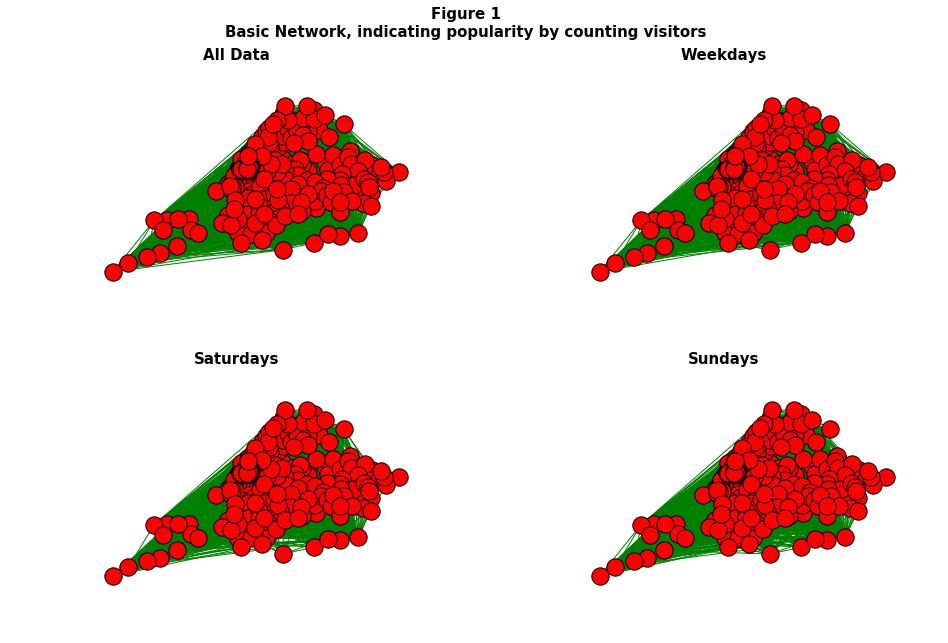

In [13]:
TweetGraph, ZipPosition = [1,2,3,4], [1,2,3,4]
fig1 = plt.figure(num = 1, figsize = (16, 10))
plt.suptitle('Figure 1\nBasic Network, indicating popularity by counting visitors'\
                     , fontweight="bold", size=15)
for i in range(4):
    TweetGraph[i], ZipPosition[i] = Network_Draw_Step0(i+1, 1)

In [14]:
TCC, T_PR = [1,2,3,4], [1,2,3,4]
for i in range(4):
    TCC[i] = list(nx.connected_component_subgraphs(TweetGraph[i], copy=True))[0]
    T_PR[i] = nx.pagerank(TCC[i],0.85)

In [17]:
def Network_Draw_Pagerank(date_index = 1):
    """This function is for plotting our network based on zipcodes
    And the input argument is the date_index where indice 1, 2, 3, 4
    indicate AllData, Weekdays, Saturdays and Sundays, respectively,
    with index 1 being the default value"""
    if date_index == 2:
        dataset = WkdData
    elif date_index == 3:
        dataset = SatData
    elif date_index == 4:
        dataset = SunData
    else:
        date_index = 1
        dataset = AllData
    
    datanet = Net[date_index - 1]
        
    zipcode_all = list(sorted(set(twitter_file.ZipCode)))

    zip_exist = []
    for i in zipcode_all:
        if i in list(USzipcode.ZipCode):
            zip_exist.append(i)
    zipPos = {x:USZipPos[x] for x in zip_exist}
    datanet = datanet[datanet.zip1.isin(zip_exist) & datanet.zip2.isin(zip_exist)]
    
    TweetGraph = nx.Graph()
    TweetGraph.add_nodes_from(zip_exist)
  
    edgelist = [0] * len(datanet)
    for i in range(len(datanet)):
        edgelist[i] = (datanet.iloc[i, 0], datanet.iloc[i, 1])
    TweetGraph.add_edges_from(edgelist)
  
    edgelist = [0] * len(datanet)
    for i in range(len(datanet)):
        edgelist[i] = (datanet.iloc[i, 0], datanet.iloc[i, 1])
    TweetGraph.add_edges_from(edgelist)
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    #visualize the network

    plt.subplot(220 + date_index)
    plt.title(title[date_index - 1], fontweight="bold", size=15)
    nx.draw(TweetGraph, pos = zipPos, node_size = 1E5 * np.array(T_PR[date_index - 1].values()),edge_color = 'g')
    
    return TweetGraph

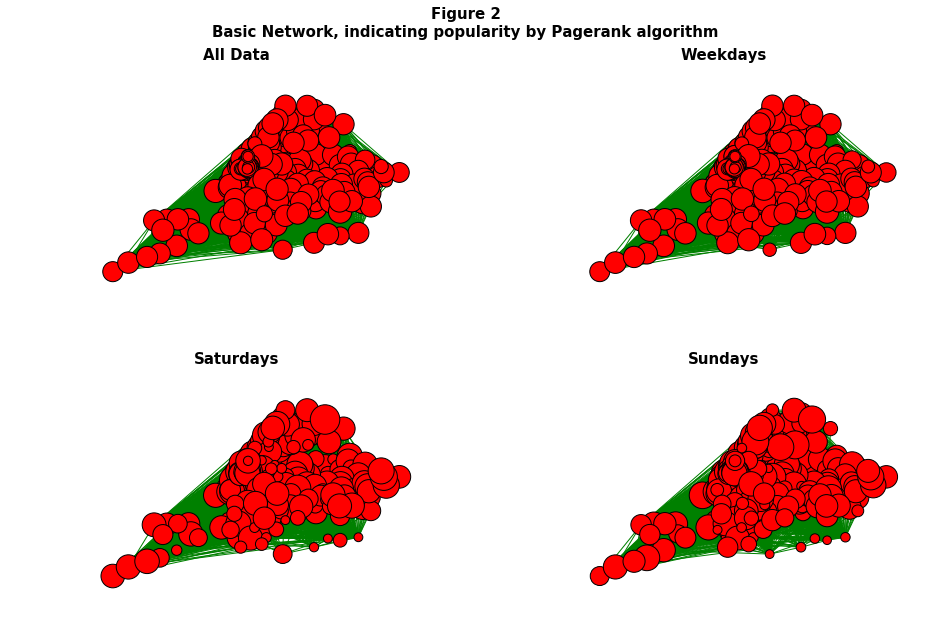

In [18]:
Tweet_PR = [1,2,3,4]
fig2 = plt.figure(num = 2, figsize = (16, 10))
plt.suptitle('Figure 2\nBasic Network, indicating popularity by Pagerank algorithm'\
                     , fontweight="bold", size=15)
for i in range(4):
    Tweet_PR[i] = Network_Draw_Pagerank(i+1)

The above plots are for experiments, and we will get back to page rank topic in the future when we start working on probablistic methods. (--week 3)

### Step 4, plot actual geometric map and prepare for community detection

In [19]:
def NYCMapShape(date_index = 1):
    #x is a dictionary (zip codes vs values)
    if date_index in [2,3,4]:
        x = Pop[date_index - 1]
    else:
        x = Pop[0]

    if max([a-int(a) for a in x.values()])==0: #if dealing with categries
        cmap = matplotlib.cm.hsv(np.linspace(0,1,max(x.values())+2))
        mode = 1
    else:
        cmap = matplotlib.cm.cool(np.linspace(0,1,128))
        mode = 2
        v2 = log(max(x.values()))
        v1 = log(min(x.values()))
        
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    ax = fig3.add_subplot(220 + date_index)   #note this fig3 for potential code modification
    plt.title(title[date_index - 1], fontweight="bold", size=15)
    for s in range(0,len(zipsf_records)):
        z = int(zipsf_records[s][1][-5:])
        if z in x.keys():        #if z is in our zipcode list
            # from here
            k = x[z]             #then k is z's coordinates--longitude & latitude
            if mode == 2:
                k = int((log(k)-v1)/(v2-v1)*127.9999)
            c = cmap[k][0:3]
            shape = zipsf_shape[s]
            x_ = [i[0] for i in shape.shape.points]
            y_ = [i[1] for i in shape.shape.points]
            poly = Polygon(zip(x_,y_))
            #plt.fill(x,y,color=my_cmap[s])
            ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.5, zorder = 2))
    ax.axis('scaled')
    ax.legend()

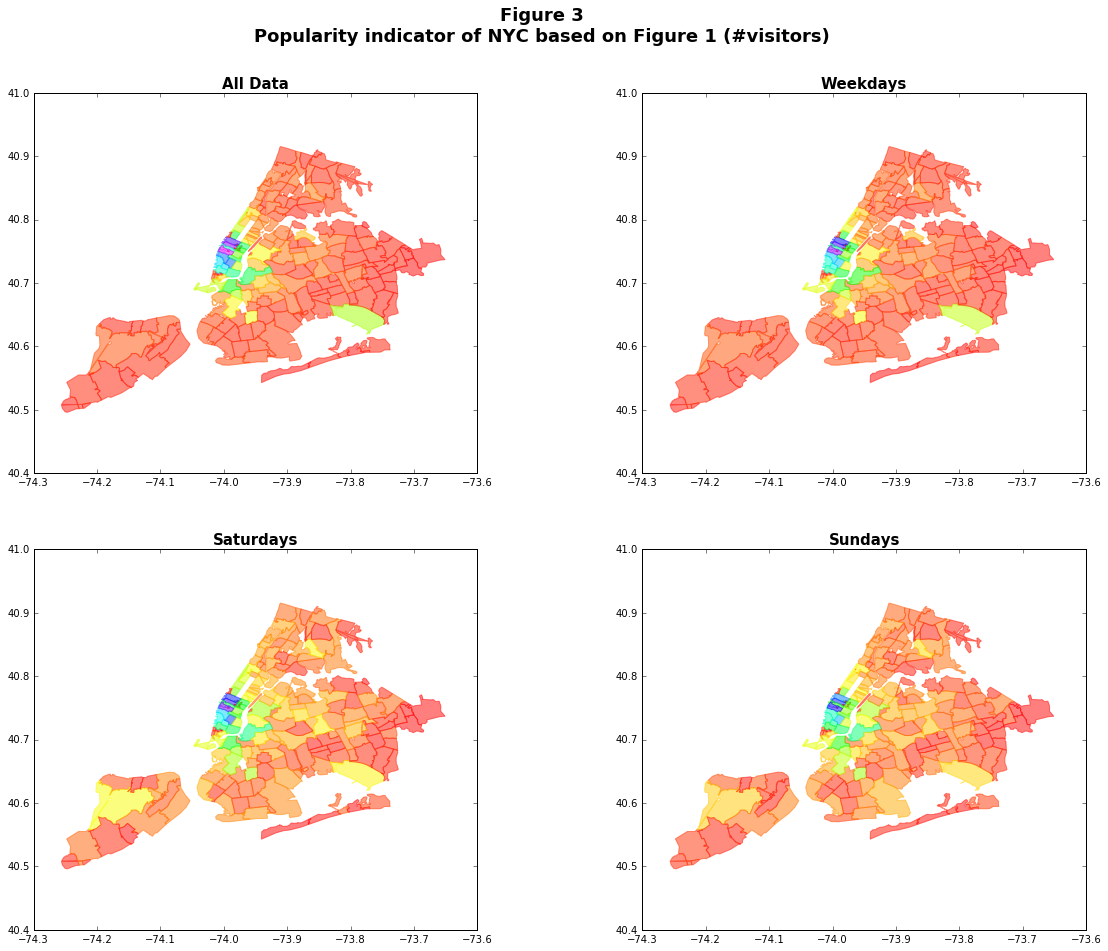

In [21]:
fig3 = plt.figure(num = 3, figsize = (20,15))
plt.suptitle('Figure 3\nPopularity indicator of NYC based on Figure 1 (#visitors)', fontweight="bold", size=18)
for i in range(4):
    NYCMapShape(i+1)

### Step 5, proceed to Community Detection

Start with Louvain method, then try combo algorithm with Inf, 2, and 4 communities parititions

* Please note that you may have to downgrade the version of package networkx from 1.11 to 1.9.1 in order to successfully plot the graph  (--week 3, March 3rd 2016)

In [22]:
#add unit weights to unweighted network nodes
def make_weighted(G, zip_network):
    WG=G
    lzn = range(len(zip_network))
    edge = [(zip_network.iloc[i,0], zip_network.iloc[i,1]) for i in lzn]
    weight = [zip_network.iloc[i,2] for i in lzn]
    weight_list = dict(zip(edge, weight))
    for e in WG.edges():
        if e in weight_list.keys():
            WG[e[0]][e[1]]['weight'] = weight_list[e]
        else:
            WG[e[0]][e[1]]['weight'] = weight_list[(e[1], e[0])]
    return WG

In [23]:
def modularity(G, partition):
    #compute network modularity according to the given partitioning
    nodes=G.nodes()
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
                if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                    if G.has_edge(a,b):
                        e=G[a][b]['weight']
                    else:
                        e=0
                    M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M

Louvain method, apply preinstalled function community.best_partition to obtain **BestPart**, for future plotting and modularity computing

Also, store weighted graph in **Tweet_weighted_graph**, with the weights being number of visitors who visit both nodes (zip1 and zip2)

In [24]:
Tweet_weighted_graph, BestPart = [1,2,3,4], [1,2,3,4]
for i in range(4):
    Tweet_weighted_graph[i] = make_weighted(TweetGraph[i], Net[i])
    BestPart[i] = community.best_partition(Tweet_weighted_graph[i])

Next, proceed with professor's algorithm __combo__, try Inf partition along with 2 and 4 partitions

In [28]:
#visualize network partitioning given node locations pos
def Partition_Draw(G, partition, pos, plot_index):
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    plt.subplot(221 + plot_index)
    plt.title(title[plot_index], fontweight="bold", size=15)
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
    nx.draw(G,pos=pos,with_labels=False,arrows=True,node_size=300,node_color=c,width=1,edge_color='k')

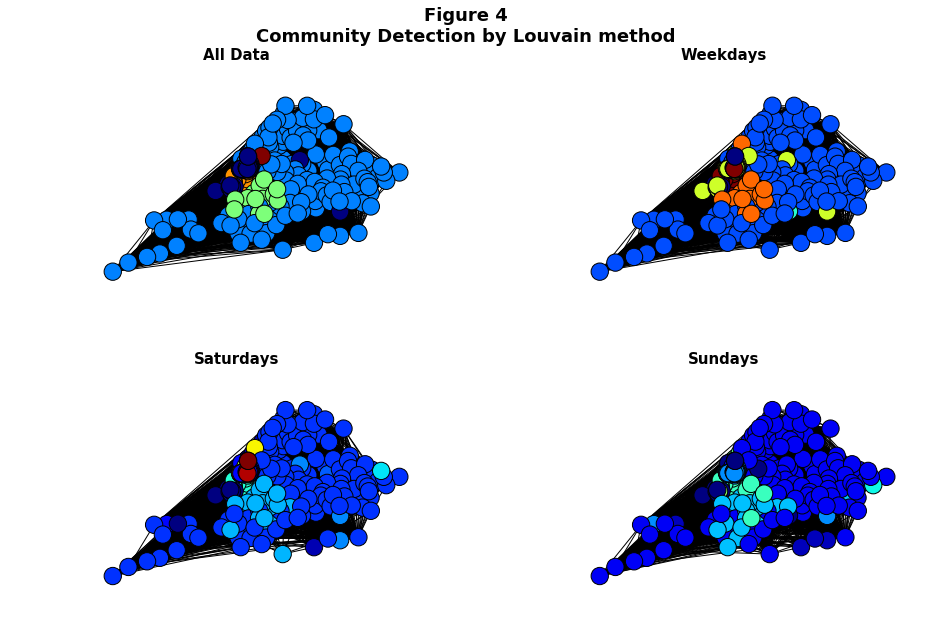

In [29]:
fig4 = plt.figure(num = 4, figsize = (16, 10))
plt.suptitle('Figure 4\nCommunity Detection by Louvain method', fontweight="bold", size=18)
for i in range(4):
    Partition_Draw(Tweet_weighted_graph[i], BestPart[i], ZipPosition[i], i)

### Part A, Loop-edges are included, we will draw graphs and calculate modularities respectively, given:
* Louvain method, labeled "**BestPart**"
* Combo method:
    * "infinite" for optimal result, labeled "**ComboPartInf**"
    * "2" for two-communities partition, labeled "**ComboPart2**"
    * "4" for four-communities partition, labeled "**ComboPart4**"

In [25]:
import os
workfolder='/Users/CQ/Documents/Project1/CommunityDetection'
os.chdir(workfolder)

In [26]:
#interface for running compiled combo over the network G given a maximal number of communities maxcom
def getComboPartition(G, maxcom):
    #save network in net format
    nodes={}
    nodenum={}
    i=0
    #create a dictionary transforming nodes to unique numbers
    for n in G.nodes():
        nodenum[n]=i
        nodes[i]=n
        i+=1
    f = open('combo/temp.net', 'w')
    f.write('*Arcs\n')
    for e in G.edges(data=True):
        f.write('{0} {1} {2}\n'.format(nodenum[e[0]],nodenum[e[1]],e[2]['weight']))
    f.close()
    #run combo
    command=workfolder+'/combo/comboCPP combo/temp.net'
    if maxcom<Inf:
        command=command+' {0}'.format(maxcom)  
    os.system(command)
    #read resulting partition
    f = open('combo/temp_comm_comboC++.txt', 'r')
    i=0
    partition={}
    for line in f:
        partition[nodes[i]]=int(line)
        i+=1
    return partition

In [27]:
ComboPartInf, ComboPart2, ComboPart4 = [1,2,3,4], [1,2,3,4], [1,2,3,4]
for i in range(4):
    ComboPartInf[i] = getComboPartition(Tweet_weighted_graph[i], Inf)
    ComboPart2[i] = getComboPartition(Tweet_weighted_graph[i], 2)
    ComboPart4[i] = getComboPartition(Tweet_weighted_graph[i], 4)

In [30]:
Tweet_mapping = [1,2,3,4]
for j in range(4):
    Tweet_mapping[j] = {TweetGraph[j].nodes()[i-1]:TweetGraph[j].nodes()[i] for i in range(len(TweetGraph[j].nodes()))}

In [31]:
def CommPartShape(fig, partition, mapping, date_index):

    lzipsf = len(zipsf_records)
    cmap = matplotlib.cm.hsv(np.linspace(0,1,max(partition.values())+2))
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index]+', modularity %f' % modularity(Tweet_weighted_graph[date_index],\
                                                               partition), fontweight="bold", size=15)
    
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in mapping.keys():
            c = cmap[partition[mapping[z]]][0:3]
            zip_shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in zip_shape.shape.points]
            poly = Polygon(w)
            ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.5, zorder = 2))

    ax.axis('scaled')
    ax.legend()

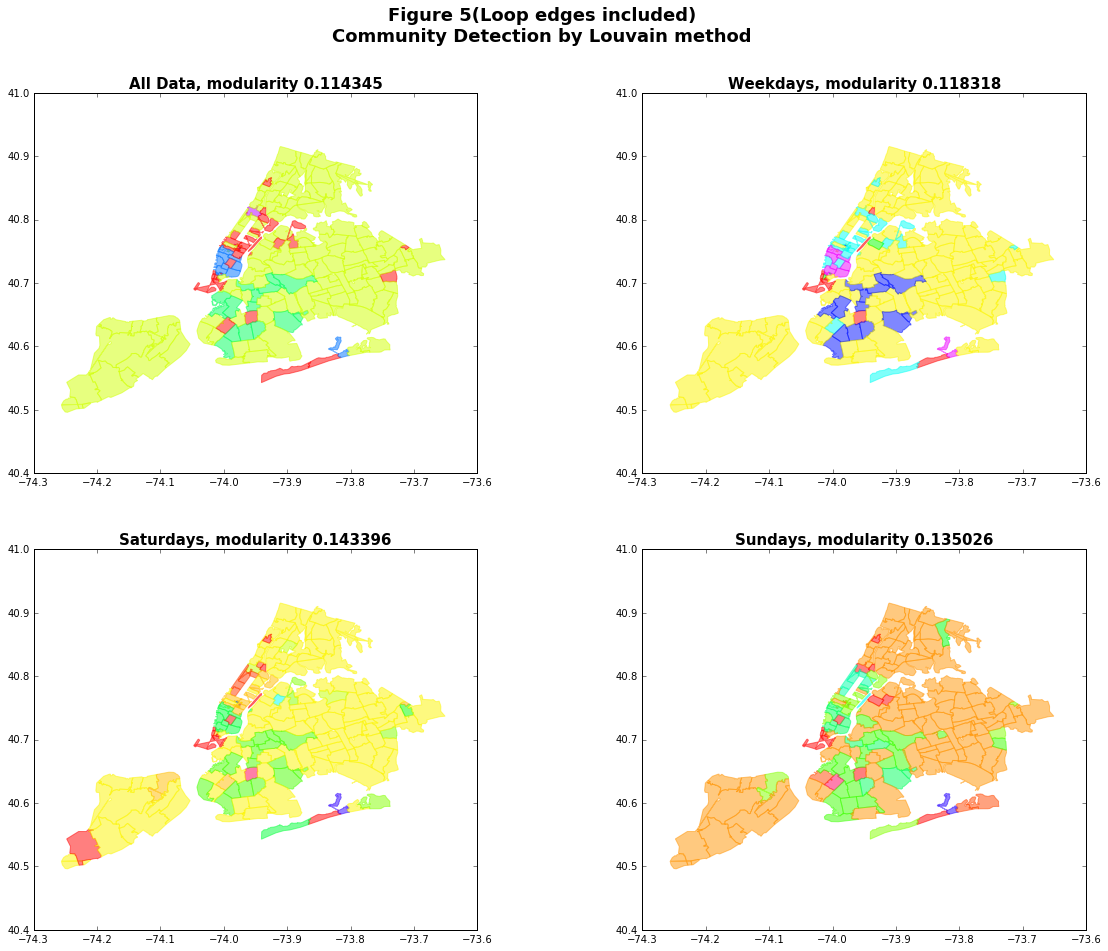

In [46]:
fig5 = plt.figure(num = 5, figsize = (20, 15))
plt.suptitle('Figure 5(Loop edges included)\nCommunity Detection by Louvain method', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig5, BestPart[i], Tweet_mapping[i], i)

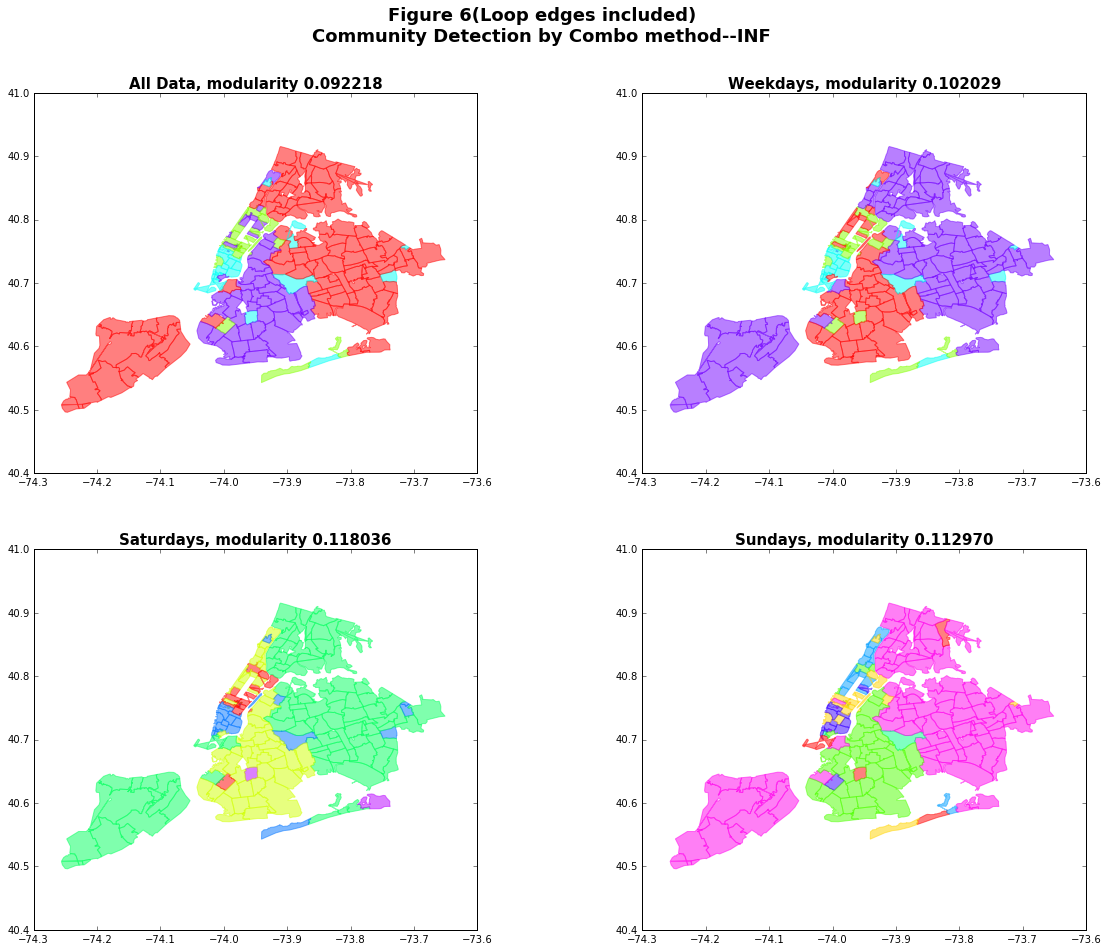

In [47]:
fig6 = plt.figure(num = 6, figsize = (20, 15))
plt.suptitle('Figure 6(Loop edges included)\nCommunity Detection by Combo method--INF', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig6, ComboPartInf[i], Tweet_mapping[i], i)

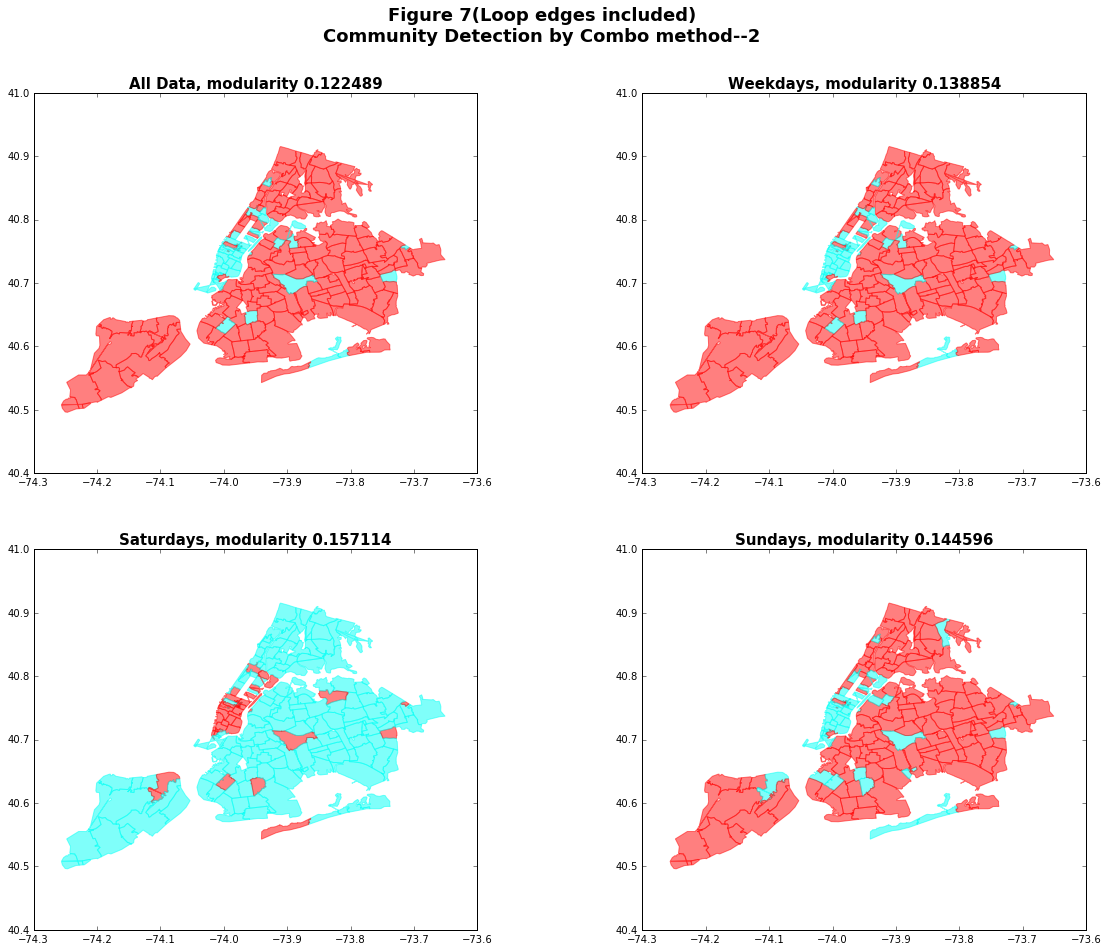

In [48]:
fig7 = plt.figure(num = 7, figsize = (20, 15))
plt.suptitle('Figure 7(Loop edges included)\nCommunity Detection by Combo method--2', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig7, ComboPart2[i], Tweet_mapping[i], i)

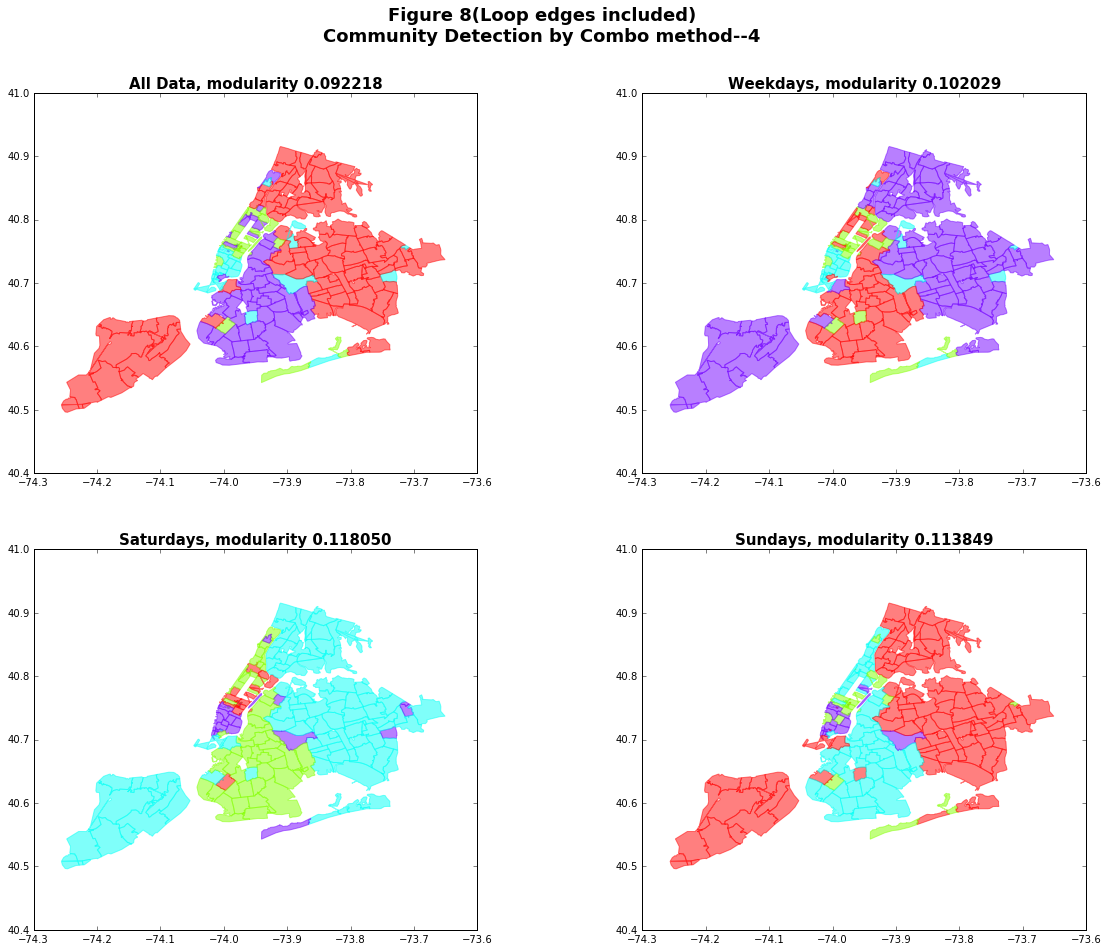

In [49]:
fig8 = plt.figure(num = 8, figsize = (20, 15))
plt.suptitle('Figure 8(Loop edges included)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig8, ComboPart4[i], Tweet_mapping[i], i)

### Part B, Loop-edges are NOT included, similarly draw graphs and calculate modularities respectively, given:
* Louvain method, labeled "**NLEBestPart**"
* Combo method:
    * "infinite" for optimal result, labeled "**NLEComboPartInf**"
    * "2" for two-communities partition, labeled "**NLEComboPart2**"
    * "4" for four-communities partition, labeled "**NLEComboPart4**"

In [36]:
#remove loop edges from a network
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU

In [37]:
#consider undirected version of the network without loops (for Louvain)
NoLoopGraph, NLEBestPart, NLEComboPartInf, NLEComboPart2, NLEComboPart4 = [1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4]
for i in range(4):
    NoLoopGraph[i] = remove_loops(Tweet_weighted_graph[i])
    NLEBestPart[i] = community.best_partition(NoLoopGraph[i])    
    NLEComboPartInf[i] = getComboPartition(NoLoopGraph[i], Inf)
    NLEComboPart2[i] = getComboPartition(NoLoopGraph[i], 2)
    NLEComboPart4[i] = getComboPartition(NoLoopGraph[i], 4)

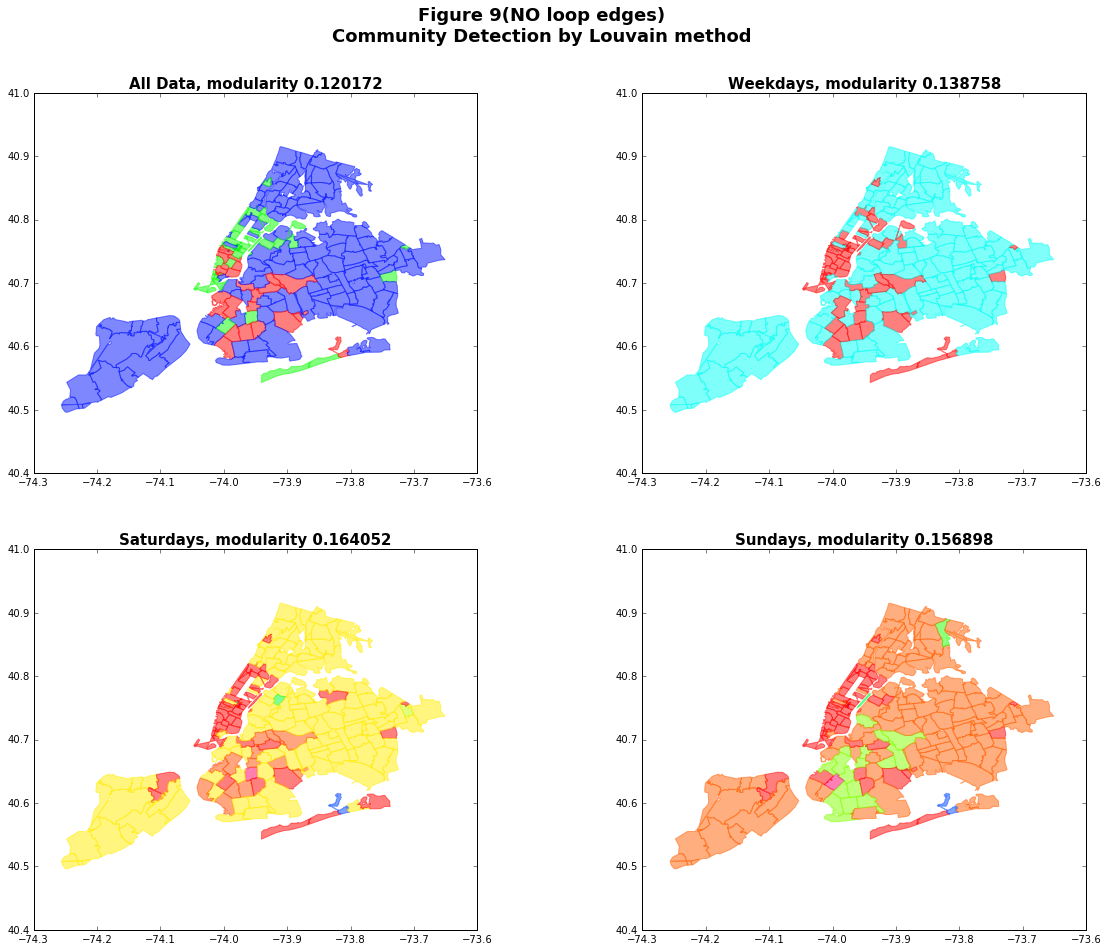

In [38]:
fig9 = plt.figure(num = 9, figsize = (20, 15))
plt.suptitle('Figure 9(NO loop edges)\nCommunity Detection by Louvain method', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig9, NLEBestPart[i], Tweet_mapping[i], i)

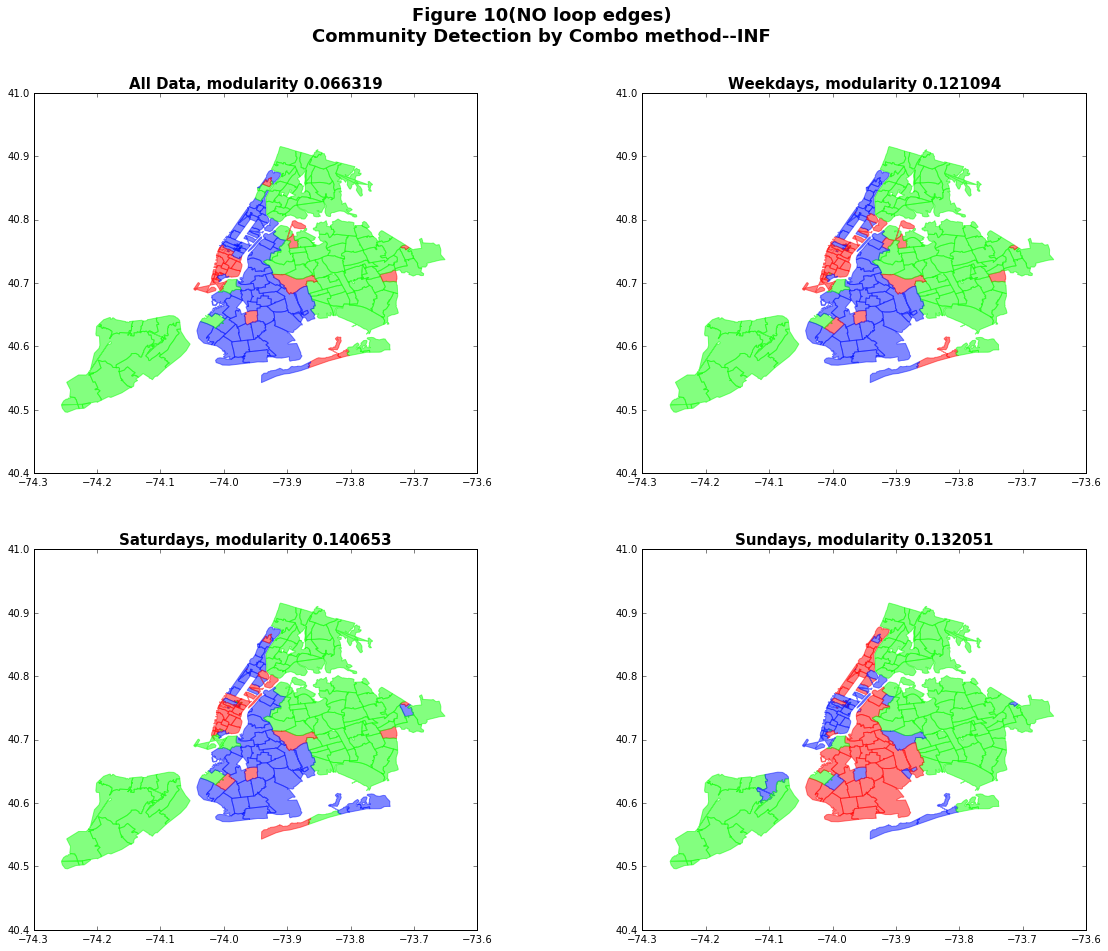

In [42]:
fig10 = plt.figure(num = 10, figsize = (20, 15))
plt.suptitle('Figure 10(NO loop edges)\nCommunity Detection by Combo method--INF', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig10, NLEComboPartInf[i], Tweet_mapping[i], i)

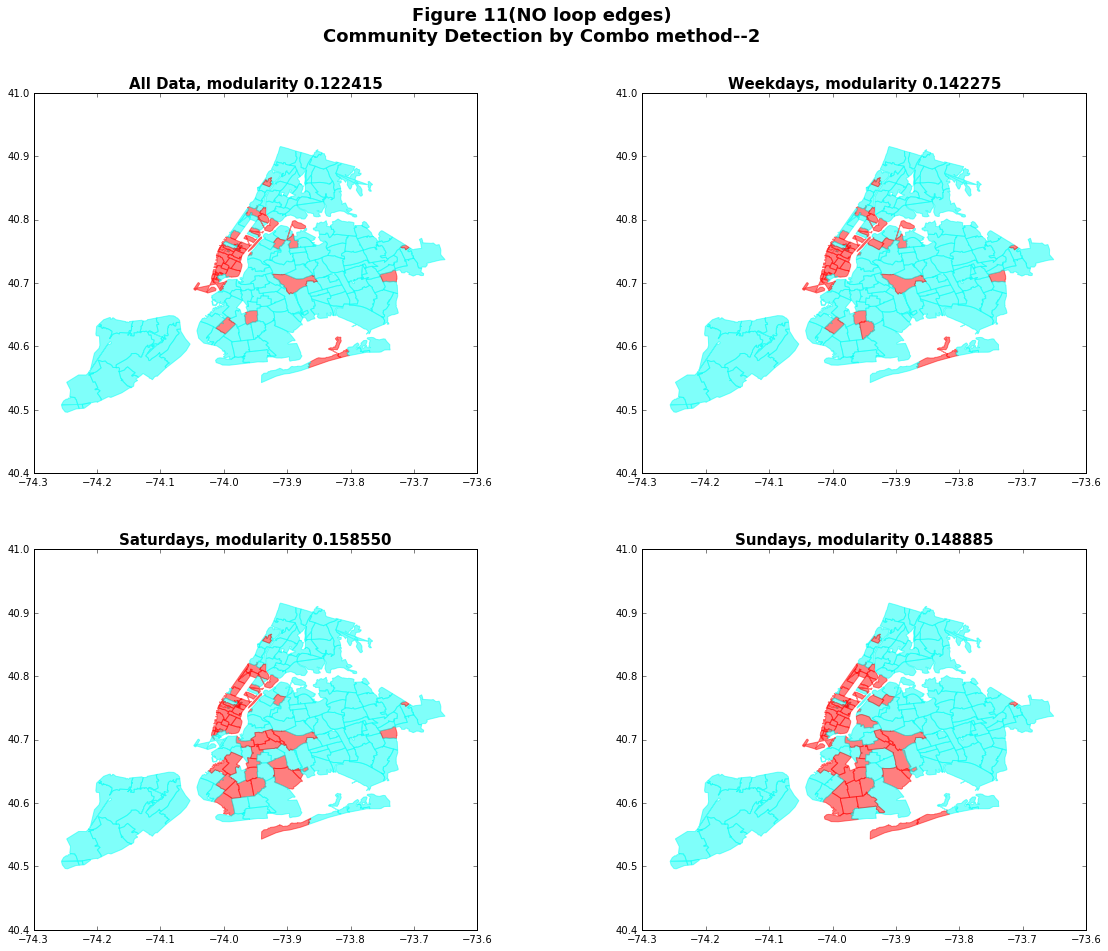

In [43]:
fig11 = plt.figure(num = 11, figsize = (20, 15))
plt.suptitle('Figure 11(NO loop edges)\nCommunity Detection by Combo method--2', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig11, NLEComboPart2[i], Tweet_mapping[i], i)

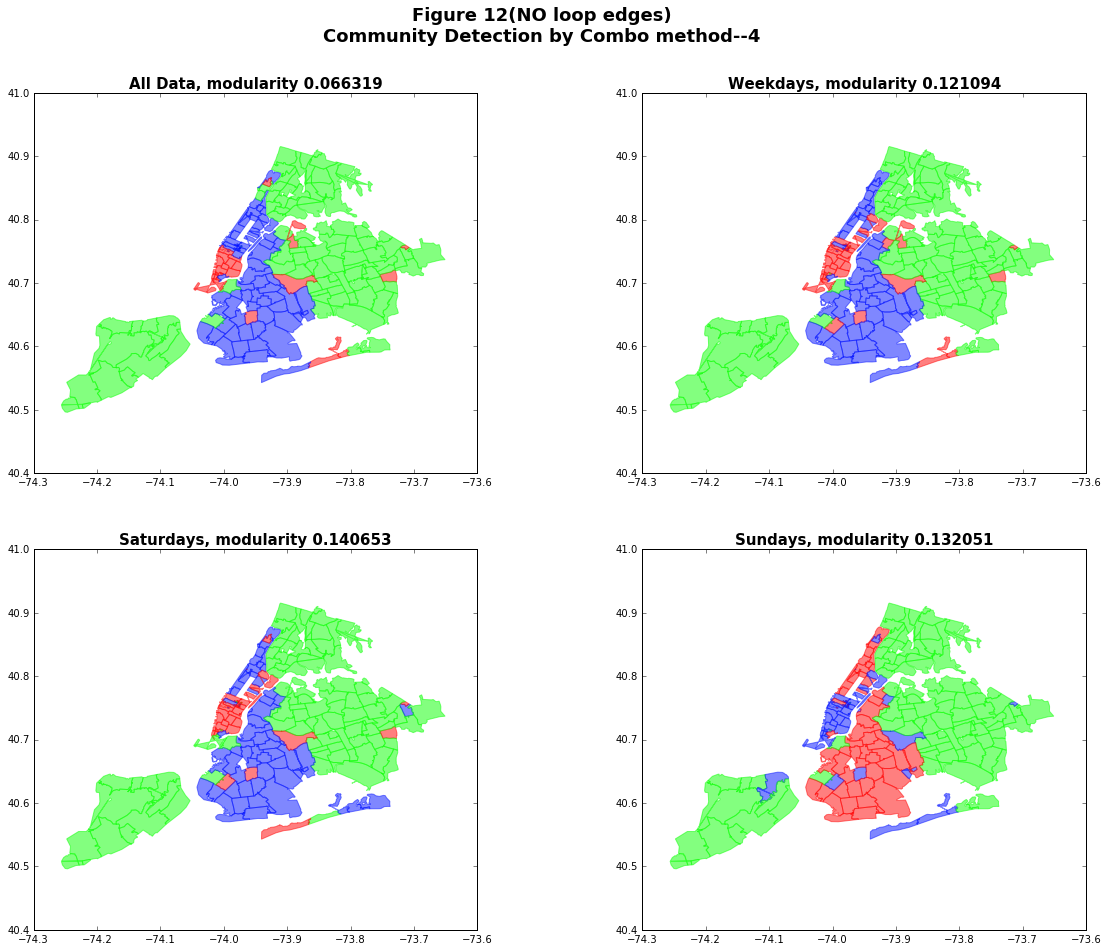

In [44]:
fig12 = plt.figure(num = 12, figsize = (20, 15))
plt.suptitle('Figure 12(NO loop edges)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig12, NLEComboPart4[i], Tweet_mapping[i], i)